# Neural Granger Causality

This colab is inspired by the work mentioned in below paper and it is intended to serve as a playground to further experiment with the models described in it.

[Alex Tank, Ian Covert, Nicholas Foti, Ali Shojaie, Emily Fox. "Neural Granger Causality." Transactions on Pattern Analysis and Machine Intelligence, 2021](https://arxiv.org/abs/1802.05842)

Note: Highly recommend changing runtime to GPU before you start training your model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn as nn
import tqdm
from copy import deepcopy
from scipy.integrate import odeint
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score, balanced_accuracy_score, \
    precision_score, recall_score

device = torch.device('cuda')

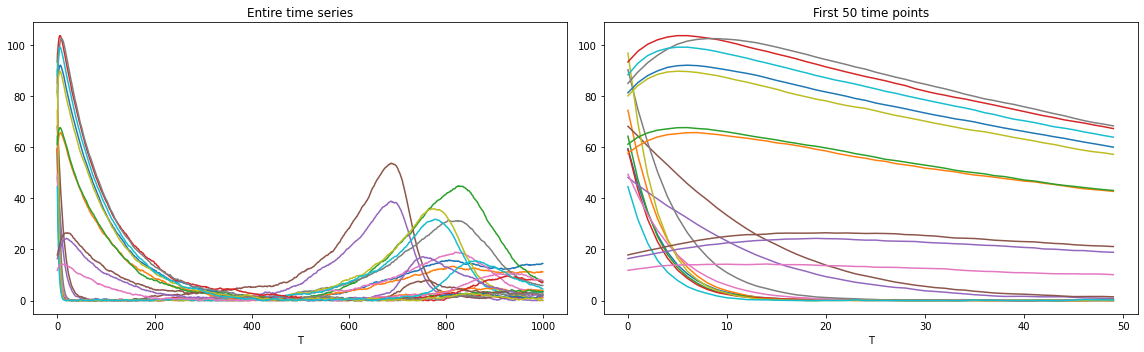

In [ ]:
#@title Choose your simulation

simulation = "Multi Lotka-Volterra" #@param ["VAR Process", "Lorenz-96", "Multi Lotka-Volterra", "fMRI"]


# VAR Process Simulation

def simulate_var(p, T, lag, sparsity=0.2, beta_value=1.0, sd=0.1, seed=0):
    if seed is not None:
        np.random.seed(seed)

    # Set up coefficients and Granger causality ground truth.
    GC = np.eye(p, dtype=int)
    beta = np.eye(p) * beta_value

    num_nonzero = int(p * sparsity) - 1
    for i in range(p):
        choice = np.random.choice(p - 1, size=num_nonzero, replace=False)
        choice[choice >= i] += 1
        beta[i, choice] = beta_value
        GC[i, choice] = 1

    beta = np.hstack([beta for _ in range(lag)])
    beta = make_var_stationary(beta)

    # Generate data.
    burn_in = 100
    errors = np.random.normal(scale=sd, size=(p, T + burn_in))
    X = np.zeros((p, T + burn_in))
    X[:, :lag] = errors[:, :lag]
    for t in range(lag, T + burn_in):
        X[:, t] = np.dot(beta, X[:, (t-lag):t].flatten(order='F'))
        X[:, t] += + errors[:, t-1]

    return X.T[burn_in:], beta, GC

def make_var_stationary(beta, radius=0.97):
    '''Rescale coefficients of VAR model to make stable.'''
    p = beta.shape[0]
    lag = beta.shape[1] // p
    bottom = np.hstack((np.eye(p * (lag - 1)), np.zeros((p * (lag - 1), p))))
    beta_tilde = np.vstack((beta, bottom))
    eigvals = np.linalg.eigvals(beta_tilde)
    max_eig = max(np.abs(eigvals))
    nonstationary = max_eig > radius
    if nonstationary:
        return make_var_stationary(0.95 * beta, radius)
    else:
        return beta

# Lorenz-96 Simulation

def lorenz(x, t, F):
    '''Partial derivatives for Lorenz-96 ODE.'''
    p = len(x)
    dxdt = np.zeros(p)
    for i in range(p):
        dxdt[i] = (x[(i+1) % p] - x[(i-2) % p]) * x[(i-1) % p] - x[i] + F

    return dxdt


def simulate_lorenz_96(p, T, F=10.0, delta_t=0.1, sd=0.1, burn_in=1000,
                       seed=0):
    if seed is not None:
        np.random.seed(seed)

    # Use scipy to solve ODE.
    x0 = np.random.normal(scale=0.01, size=p)
    t = np.linspace(0, (T + burn_in) * delta_t, T + burn_in)
    X = odeint(lorenz, x0, t, args=(F,))
    X += np.random.normal(scale=sd, size=(T + burn_in, p))

    # Set up Granger causality ground truth.
    GC = np.zeros((p, p), dtype=int)
    for i in range(p):
        GC[i, i] = 1
        GC[i, (i + 1) % p] = 1
        GC[i, (i - 1) % p] = 1
        GC[i, (i - 2) % p] = 1

    return X[burn_in:], GC

class MultiLotkaVolterra:
    def __init__(self, p=10, d=2, alpha=1.2, beta=0.2, gamma=1.1, delta=0.05, sigma=0.1):
        """
        Dynamical multi-species Lotka--Volterra system. The original two-species Lotka--Volterra is a special case
        with p = 1 , d = 1.
        @param p: number of predator/prey species. Total number of variables is 2*p.
        @param d: number of GC parents per variable.
        @param alpha: strength of interaction of a prey species with itself.
        @param beta: strength of predator -> prey interaction.
        @param gamma: strength of interaction of a predator species with itself.
        @param delta: strength of prey -> predator interaction.
        @param sigma: scale parameter for the noise.
        """

        assert p >= d and p % d == 0

        self.p = p
        self.d = d

        # Coupling strengths
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.sigma = sigma

    def simulate(self, t: int, dt=0.01, downsample_factor=10, seed=None):
        if seed is not None:
            np.random.seed(seed)
        xs_0 = np.random.uniform(10, 100, size=(self.p, ))
        ys_0 = np.random.uniform(10, 100, size=(self.p, ))

        ts = np.arange(t) * dt

        # Simulation Loop
        xs = np.zeros((t, self.p))
        ys = np.zeros((t, self.p))
        xs[0, :] = xs_0
        ys[0, :] = ys_0
        for k in range(t - 1):
            xs[k + 1, :], ys[k + 1, :] = self.next(xs[k, :], ys[k, :], dt)

        causal_struct = np.zeros((self.p * 2, self.p * 2))
        signed_causal_struct = np.zeros((self.p * 2, self.p * 2))
        for j in range(self.p):
            # Self causation
            causal_struct[j, j] = 1
            causal_struct[j + self.p, j + self.p] = 1

            signed_causal_struct[j, j] = +1
            signed_causal_struct[j + self.p, j + self.p] = -1

            # Predator-prey relationships
            causal_struct[j, int(np.floor((j + self.d) / self.d) * self.d - 1 + self.p - self.d + 1):int(np.floor((j + self.d) / self.d) * self.d + self.p)] = 1
            causal_struct[j + self.p, int(np.floor((j + self.d) / self.d) * self.d - self.d + 1 - 1):int(np.floor((j + self.d) / self.d) * self.d)] = 1

            signed_causal_struct[j, int(np.floor((j + self.d) / self.d) * self.d - 1 + self.p - self.d + 1):int(np.floor((j + self.d) / self.d) * self.d + self.p)] = -1
            signed_causal_struct[j + self.p, int(np.floor((j + self.d) / self.d) * self.d - self.d + 1 - 1):int(np.floor((j + self.d) / self.d) * self.d)] = +1

        # return [np.concatenate((xs[::downsample_factor, :], ys[::downsample_factor, :]), 1)], causal_struct, signed_causal_struct
        return np.concatenate((xs, ys), 1), causal_struct, signed_causal_struct

    # Dynamics
    # State transitions using the Runge-Kutta method
    def next(self, x, y, dt):
        xdot1, ydot1 = self.f(x, y)
        xdot2, ydot2 = self.f(x + xdot1 * dt / 2, y + ydot1 * dt / 2)
        xdot3, ydot3 = self.f(x + xdot2 * dt / 2, y + ydot2 * dt / 2)
        xdot4, ydot4 = self.f(x + xdot3 * dt, y + ydot3 * dt)
        # Add noise to simulations
        xnew = x + (xdot1 + 2 * xdot2 + 2 * xdot3 + xdot4) * dt / 6 + \
               np.random.normal(scale=self.sigma, size=(self.p, ))
        ynew = y + (ydot1 + 2 * ydot2 + 2 * ydot3 + ydot4) * dt / 6 + \
               np.random.normal(scale=self.sigma, size=(self.p, ))
        # Clip from below to prevent populations from becoming negative
        return np.maximum(xnew, 0), np.maximum(ynew, 0)

    def f(self, x, y):
        xdot = np.zeros((self.p, ))
        ydot = np.zeros((self.p, ))

        for j in range(self.p):
            y_Nxj = y[int(np.floor((j + self.d) / self.d) * self.d - self.d + 1 - 1):int(np.floor((j + self.d) /
                                                                                                  self.d) * self.d)]
            x_Nyj = x[int(np.floor((j + self.d) / self.d) * self.d - self.d + 1 - 1):int(np.floor((j + self.d) /
                                                                                                  self.d) * self.d)]
            xdot[j] = self.alpha * x[j] - self.beta * x[j] * np.sum(y_Nxj) - self.alpha * (x[j] / 200) ** 2
            ydot[j] = self.delta * np.sum(x_Nyj) * y[j] - self.gamma * y[j]
        return xdot, ydot

if simulation == "VAR Process":
  X_np, beta, GC = simulate_var(p=10, T=1000, lag=3)
elif simulation == "Lorenz-96":
  X_np, GC = simulate_lorenz_96(p=10, F=10, T=1000)
elif simulation == "Multi Lotka-Volterra":
  mlv = MultiLotkaVolterra()
  X_np, GC, GC_signed = mlv.simulate(t=1000, seed=0)
elif simulation == "fMRI":
  # Subjects can be 0 to 49 for different simulation data
  file_url = "https://raw.githubusercontent.com/i6092467/GVAR/master/datasets/fMRI/sim3/sim3_subject_5.npz"
  # raw=true is important so you download the file rather than the webpage.
  !wget https://github.com/i6092467/GVAR/blob/master/datasets/fMRI/sim3/sim3_subject_5.npz?raw=true
  # rename the file
  !mv sim3_subject_5.npz\?raw\=true data.npz
  ld = np.load("data.npz")
  X_np = ld['X_np'].T
  GC = ld['Gref']
else:
  raise ValueError('Unsupported simulation %s' % simulation)

if torch.cuda.is_available():
  X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)
else:
  X = torch.tensor(X_np[np.newaxis], dtype=torch.float32)

# To avoid huge loss numbers causing training loop to crash
if simulation == "Multi Lotka-Volterra":
  X = X / 10

# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

In [ ]:
#@title Choose your model
neural_model = "cMLP - GSGL Penalty" #@param ["cMLP - HL Penalty", "cMLP - GL Penalty", "cMLP - GSGL Penalty", "cRNN", "cLSTM"]
hidden_units = 10 #@param {type:"slider", min:10, max:500, step:10}


## Activation Helper

def activation_helper(activation, dim=None):
    if activation == 'sigmoid':
        act = nn.Sigmoid()
    elif activation == 'tanh':
        act = nn.Tanh()
    elif activation == 'relu':
        act = nn.ReLU()
    elif activation == 'leakyrelu':
        act = nn.LeakyReLU()
    elif activation is None:
        def act(x):
            return x
    else:
        raise ValueError('unsupported activation: %s' % activation)
    return act

#############
# cMLP Model
#############

class MLP(nn.Module):
    def __init__(self, num_series, lag, hidden, activation):
        super(MLP, self).__init__()
        self.activation = activation_helper(activation)

        # Set up network.
        layer = nn.Conv1d(num_series, hidden[0], lag)
        modules = [layer]

        for d_in, d_out in zip(hidden, hidden[1:] + [1]):
            layer = nn.Conv1d(d_in, d_out, 1)
            modules.append(layer)

        # Register parameters.
        self.layers = nn.ModuleList(modules)

    def forward(self, X):
        X = X.transpose(2, 1)
        for i, fc in enumerate(self.layers):
            if i != 0:
                X = self.activation(X)
            X = fc(X)

        return X.transpose(2, 1)


class cMLP(nn.Module):
    def __init__(self, num_series, lag, hidden, activation='relu'):
        '''
        cMLP model with one MLP per time series.
        Args:
          num_series: dimensionality of multivariate time series.
          lag: number of previous time points to use in prediction.
          hidden: list of number of hidden units per layer.
          activation: nonlinearity at each layer.
        '''
        super(cMLP, self).__init__()
        self.p = num_series
        self.lag = lag
        self.activation = activation_helper(activation)

        # Set up networks.
        self.networks = nn.ModuleList([
            MLP(num_series, lag, hidden, activation)
            for _ in range(num_series)])

    def forward(self, X):
        '''
        Perform forward pass.
        Args:
          X: torch tensor of shape (batch, T, p).
        '''
        return torch.cat([network(X) for network in self.networks], dim=2)

    def GC(self, threshold=True, ignore_lag=True):
        '''
        Extract learned Granger causality.
        Args:
          threshold: return norm of weights, or whether norm is nonzero.
          ignore_lag: if true, calculate norm of weights jointly for all lags.
        Returns:
          GC: (p x p) or (p x p x lag) matrix. In first case, entry (i, j)
            indicates whether variable j is Granger causal of variable i. In
            second case, entry (i, j, k) indicates whether it's Granger causal
            at lag k.
        '''
        if ignore_lag:
            GC = [torch.norm(net.layers[0].weight, dim=(0, 2))
                  for net in self.networks]
        else:
            GC = [torch.norm(net.layers[0].weight, dim=0)
                  for net in self.networks]
        GC = torch.stack(GC)
        if threshold:
            return (GC > 0).int()
        else:
            return GC


#############
# cRNN Model
#############


class RNN(nn.Module):
    def __init__(self, num_series, hidden, nonlinearity):
        '''
        RNN model with output layer to generate predictions.
        Args:
          num_series: number of input time series.
          hidden: number of hidden units.
        '''
        super(RNN, self).__init__()
        self.p = num_series
        self.hidden = hidden

        # Set up network.
        self.rnn = nn.RNN(num_series, hidden, nonlinearity=nonlinearity,
                          batch_first=True)
        self.rnn.flatten_parameters()
        self.linear = nn.Conv1d(hidden, 1, 1)

    def init_hidden(self, batch):
        '''Initialize hidden states for RNN cell.'''
        device = self.rnn.weight_ih_l0.device
        return torch.zeros(1, batch, self.hidden, device=device)

    def forward(self, X, hidden=None, truncation=None):
        # Set up hidden state.
        if hidden is None:
            hidden = self.init_hidden(X.shape[0])

        # Apply RNN.
        X, hidden = self.rnn(X, hidden)

        # Calculate predictions using output layer.
        X = X.transpose(2, 1)
        X = self.linear(X)
        return X.transpose(2, 1), hidden


class cRNN(nn.Module):
    def __init__(self, num_series, hidden, nonlinearity='relu'):
        '''
        cRNN model with one RNN per time series.
        Args:
          num_series: dimensionality of multivariate time series.
          hidden: number of units in RNN cell.
          nonlinearity: nonlinearity of RNN cell.
        '''
        super(cRNN, self).__init__()
        self.p = num_series
        self.hidden = hidden

        # Set up networks.
        self.networks = nn.ModuleList([
            RNN(num_series, hidden, nonlinearity) for _ in range(num_series)])

    def forward(self, X, hidden=None):
        '''
        Perform forward pass.
        Args:
          X: torch tensor of shape (batch, T, p).
          hidden: hidden states for RNN cell.
        '''
        if hidden is None:
            hidden = [None for _ in range(self.p)]
        pred = [self.networks[i](X, hidden[i])
                for i in range(self.p)]
        pred, hidden = zip(*pred)
        pred = torch.cat(pred, dim=2)
        return pred, hidden

    def GC(self, threshold=True):
        '''
        Extract learned Granger causality.
        Args:
          threshold: return norm of weights, or whether norm is nonzero.
        Returns:
          GC: (p x p) matrix. Entry (i, j) indicates whether variable j is
            Granger causal of variable i.
        '''
        GC = [torch.norm(net.rnn.weight_ih_l0, dim=0)
              for net in self.networks]
        GC = torch.stack(GC)
        if threshold:
            return (GC > 0).int()
        else:
            return GC


#############
# cLSTM Model
#############

class LSTM(nn.Module):
    def __init__(self, num_series, hidden):
        '''
        LSTM model with output layer to generate predictions.
        Args:
          num_series: number of input time series.
          hidden: number of hidden units.
        '''
        super(LSTM, self).__init__()
        self.p = num_series
        self.hidden = hidden

        # Set up network.
        self.lstm = nn.LSTM(num_series, hidden, batch_first=True)
        self.lstm.flatten_parameters()
        self.linear = nn.Conv1d(hidden, 1, 1)

    def init_hidden(self, batch):
        '''Initialize hidden states for LSTM cell.'''
        device = self.lstm.weight_ih_l0.device
        return (torch.zeros(1, batch, self.hidden, device=device),
                torch.zeros(1, batch, self.hidden, device=device))

    def forward(self, X, hidden=None):
        # Set up hidden state.
        if hidden is None:
            hidden = self.init_hidden(X.shape[0])

        # Apply LSTM.
        X, hidden = self.lstm(X, hidden)

        # Calculate predictions using output layer.
        X = X.transpose(2, 1)
        X = self.linear(X)
        return X.transpose(2, 1), hidden


class cLSTM(nn.Module):
    def __init__(self, num_series, hidden):
        '''
        cLSTM model with one LSTM per time series.
        Args:
          num_series: dimensionality of multivariate time series.
          hidden: number of units in LSTM cell.
        '''
        super(cLSTM, self).__init__()
        self.p = num_series
        self.hidden = hidden

        # Set up networks.
        self.networks = nn.ModuleList([
            LSTM(num_series, hidden) for _ in range(num_series)])

    def forward(self, X, hidden=None):
        '''
        Perform forward pass.
        Args:
          X: torch tensor of shape (batch, T, p).
          hidden: hidden states for LSTM cell.
        '''
        if hidden is None:
            hidden = [None for _ in range(self.p)]
        pred = [self.networks[i](X, hidden[i])
                for i in range(self.p)]
        pred, hidden = zip(*pred)
        pred = torch.cat(pred, dim=2)
        return pred, hidden

    def GC(self, threshold=True):
        '''
        Extract learned Granger causality.
        Args:
          threshold: return norm of weights, or whether norm is nonzero.
        Returns:
          GC: (p x p) matrix. Entry (i, j) indicates whether variable j is
            Granger causal of variable i.
        '''
        GC = [torch.norm(net.lstm.weight_ih_l0, dim=0)
              for net in self.networks]
        GC = torch.stack(GC)
        if threshold:
            return (GC > 0).int()
        else:
            return GC


if neural_model in [ "cMLP - HL Penalty", "cMLP - GL Penalty", "cMLP - GSGL Penalty"]:
  if torch.cuda.is_available():
    model = cMLP(X.shape[-1], lag=5, hidden=[hidden_units]).cuda(device=device)
  else:
    model = cMLP(X.shape[-1], lag=5, hidden=[hidden_units])
elif neural_model == "cRNN":
  if torch.cuda.is_available():
    model = cRNN(X.shape[-1], hidden=hidden_units).cuda(device=device)
  else:
    model = cRNN(X.shape[-1], hidden=hidden_units)
elif neural_model == "cLSTM":
  if torch.cuda.is_available():
    model = cLSTM(X.shape[-1], hidden=hidden_units).cuda(device=device)
  else:
    model = cLSTM(X.shape[-1], hidden=hidden_units)
else:
  raise ValueError('Unsupported model %s' % neural_model)

In [ ]:
#@title Train your model
epochs = 500 #@param {type:"slider", min:500, max:50000, step:100}
lam =  0.002#@param {type:"number"}
lam_ridge = 1e-2 #@param {type:"number"}
lr =  5e-2#@param {type:"number"}
save_model = False #@param {type:"boolean"}
#@markdown Provide filename if loading pre-trained weights
load_pretrained_weights = False #@param {type:"boolean"}
filename = "" #@param {type:"string"}



##########################
# cMLP Training Routines
##########################

def prox_update_cmlp(network, lam, lr, penalty):
    '''
    Perform in place proximal update on first layer weight matrix.
    Args:
      network: MLP network.
      lam: regularization parameter.
      lr: learning rate.
      penalty: one of GL (group lasso), GSGL (group sparse group lasso),
        H (hierarchical).
    '''
    W = network.layers[0].weight
    hidden, p, lag = W.shape
    if penalty == 'GL':
        norm = torch.norm(W, dim=(0, 2), keepdim=True)
        W.data = ((W / torch.clamp(norm, min=(lr * lam)))
                  * torch.clamp(norm - (lr * lam), min=0.0))
    elif penalty == 'GSGL':
        norm = torch.norm(W, dim=0, keepdim=True)
        W.data = ((W / torch.clamp(norm, min=(lr * lam)))
                  * torch.clamp(norm - (lr * lam), min=0.0))
        norm = torch.norm(W, dim=(0, 2), keepdim=True)
        W.data = ((W / torch.clamp(norm, min=(lr * lam)))
                  * torch.clamp(norm - (lr * lam), min=0.0))
    elif penalty == 'H':
        # Lowest indices along third axis touch most lagged values.
        for i in range(lag):
            norm = torch.norm(W[:, :, :(i + 1)], dim=(0, 2), keepdim=True)
            W.data[:, :, :(i+1)] = (
                (W.data[:, :, :(i+1)] / torch.clamp(norm, min=(lr * lam)))
                * torch.clamp(norm - (lr * lam), min=0.0))
    else:
        raise ValueError('unsupported penalty: %s' % penalty)


def regularize_cmlp(network, lam, penalty):
    '''
    Calculate regularization term for first layer weight matrix.
    Args:
      network: MLP network.
      penalty: one of GL (group lasso), GSGL (group sparse group lasso),
        H (hierarchical).
    '''
    W = network.layers[0].weight
    hidden, p, lag = W.shape
    if penalty == 'GL':
        return lam * torch.sum(torch.norm(W, dim=(0, 2)))
    elif penalty == 'GSGL':
        return lam * (torch.sum(torch.norm(W, dim=(0, 2)))
                      + torch.sum(torch.norm(W, dim=0)))
    elif penalty == 'H':
        # Lowest indices along third axis touch most lagged values.
        return lam * sum([torch.sum(torch.norm(W[:, :, :(i+1)], dim=(0, 2)))
                          for i in range(lag)])
    else:
        raise ValueError('unsupported penalty: %s' % penalty)


def ridge_regularize_cmlp(network, lam):
    '''Apply ridge penalty at all subsequent layers.'''
    return lam * sum([torch.sum(fc.weight ** 2) for fc in network.layers[1:]])


def restore_parameters_cmlp(model, best_model):
    '''Move parameter values from best_model to model.'''
    for params, best_params in zip(model.parameters(), best_model.parameters()):
        params.data = best_params

def train_model_ista_cmlp(cmlp, X, lr, max_iter, lam=0, lam_ridge=0, penalty='H',
                          lookback=5, check_every=100, verbose=1):
    '''Train model with Adam.'''
    lag = cmlp.lag
    p = X.shape[-1]
    loss_fn = nn.MSELoss(reduction='mean')
    train_loss_list = []

    # For early stopping.
    best_it = None
    best_loss = np.inf
    best_model = None

    # Calculate smooth error.
    loss = sum([loss_fn(cmlp.networks[i](X[:, :-1]), X[:, lag:, i:i+1])
                for i in range(p)])
    ridge = sum([ridge_regularize_cmlp(net, lam_ridge) for net in cmlp.networks])
    smooth = loss + ridge

    for it in range(max_iter):
        # Take gradient step.
        smooth.backward()
        for param in cmlp.parameters():
            param.data = param - lr * param.grad

        # Take prox step.
        if lam > 0:
            for net in cmlp.networks:
                prox_update_cmlp(net, lam, lr, penalty)

        cmlp.zero_grad()

        # Calculate loss for next iteration.
        loss = sum([loss_fn(cmlp.networks[i](X[:, :-1]), X[:, lag:, i:i+1])
                    for i in range(p)])
        ridge = sum([ridge_regularize_cmlp(net, lam_ridge) for net in cmlp.networks])
        smooth = loss + ridge

        # Check progress.
        if (it + 1) % check_every == 0:
            # Add nonsmooth penalty.
            nonsmooth = sum([regularize_cmlp(net, lam, penalty)
                             for net in cmlp.networks])
            mean_loss = (smooth + nonsmooth) / p
            train_loss_list.append(mean_loss.detach())

            if verbose > 0:
                print(('-' * 10 + 'Iter = %d' + '-' * 10) % (it + 1))
                print('Loss = %f' % mean_loss)
                print('Variable usage = %.2f%%'
                      % (100 * torch.mean(cmlp.GC().float())))

            # Check for early stopping.
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_it = it
                best_model = deepcopy(cmlp)
            elif (it - best_it) == lookback * check_every:
                if verbose:
                    print('Stopping early')
                break

    # Restore best model.
    restore_parameters_cmlp(cmlp, best_model)

    return train_loss_list

##########################
# cRNN Training Routines
##########################

def prox_update_crnn(network, lam, lr):
    '''Perform in place proximal update on first layer weight matrix.'''
    W = network.rnn.weight_ih_l0
    norm = torch.norm(W, dim=0, keepdim=True)
    W.data = ((W / torch.clamp(norm, min=(lam * lr)))
              * torch.clamp(norm - (lr * lam), min=0.0))
    network.rnn.flatten_parameters()


def regularize_crnn(network, lam):
    '''Calculate regularization term for first layer weight matrix.'''
    W = network.rnn.weight_ih_l0
    return lam * torch.sum(torch.norm(W, dim=0))


def ridge_regularize_crnn(network, lam):
    '''Apply ridge penalty at linear layer and hidden-hidden weights.'''
    return lam * (
        torch.sum(network.linear.weight ** 2) +
        torch.sum(network.rnn.weight_hh_l0 ** 2))


def restore_parameters_crnn(model, best_model):
    '''Move parameter values from best_model to model.'''
    for params, best_params in zip(model.parameters(), best_model.parameters()):
        params.data = best_params


def arrange_input_crnn(data, context):
    '''
    Arrange a single time series into overlapping short sequences.
    Args:
      data: time series of shape (T, dim).
      context: length of short sequences.
    '''
    assert context >= 1 and isinstance(context, int)
    input = torch.zeros(len(data) - context, context, data.shape[1],
                        dtype=torch.float32, device=data.device)
    target = torch.zeros(len(data) - context, context, data.shape[1],
                         dtype=torch.float32, device=data.device)
    for i in range(context):
        start = i
        end = len(data) - context + i
        input[:, i, :] = data[start:end]
        target[:, i, :] = data[start+1:end+1]
    return input.detach(), target.detach()


def train_model_ista_crnn(crnn, X, context, lr, max_iter, lam=0, lam_ridge=0,
                          lookback=5, check_every=50, verbose=1):
    '''Train model with Adam.'''
    p = X.shape[-1]
    loss_fn = nn.MSELoss(reduction='mean')
    train_loss_list = []

    # Set up data.
    X, Y = zip(*[arrange_input_crnn(x, context) for x in X])
    X = torch.cat(X, dim=0)
    Y = torch.cat(Y, dim=0)

    # For early stopping.
    best_it = None
    best_loss = np.inf
    best_model = None

    # Calculate smooth error.
    pred = [crnn.networks[i](X)[0] for i in range(p)]
    loss = sum([loss_fn(pred[i][:, :, 0], Y[:, :, i]) for i in range(p)])
    ridge = sum([ridge_regularize_crnn(net, lam_ridge) for net in crnn.networks])
    smooth = loss + ridge

    for it in range(max_iter):
        # Take gradient step.
        smooth.backward()
        for param in crnn.parameters():
            param.data -= lr * param.grad

        # Take prox step.
        if lam > 0:
            for net in crnn.networks:
                prox_update_crnn(net, lam, lr)

        crnn.zero_grad()

        # Calculate loss for next iteration.
        pred = [crnn.networks[i](X)[0] for i in range(p)]
        loss = sum([loss_fn(pred[i][:, :, 0], Y[:, :, i]) for i in range(p)])
        ridge = sum([ridge_regularize_crnn(net, lam_ridge)
                     for net in crnn.networks])
        smooth = loss + ridge

        # Check progress.
        if (it + 1) % check_every == 0:
            # Add nonsmooth penalty.
            nonsmooth = sum([regularize_crnn(net, lam) for net in crnn.networks])
            mean_loss = (smooth + nonsmooth) / p
            train_loss_list.append(mean_loss.detach())

            if verbose > 0:
                print(('-' * 10 + 'Iter = %d' + '-' * 10) % (it + 1))
                print('Loss = %f' % mean_loss)
                print('Variable usage = %.2f%%'
                      % (100 * torch.mean(crnn.GC().float())))

            # Check for early stopping.
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_it = it
                best_model = deepcopy(crnn)
            elif (it - best_it) == lookback * check_every:
                if verbose:
                    print('Stopping early')
                break

    # Restore best model.
    restore_parameters_crnn(crnn, best_model)

    return train_loss_list


##########################
# cLSTM Training Routines
##########################

def prox_update_clstm(network, lam, lr):
    '''Perform in place proximal update on first layer weight matrix.'''
    W = network.lstm.weight_ih_l0
    norm = torch.norm(W, dim=0, keepdim=True)
    W.data = ((W / torch.clamp(norm, min=(lam * lr)))
              * torch.clamp(norm - (lr * lam), min=0.0))
    network.lstm.flatten_parameters()


def regularize_clstm(network, lam):
    '''Calculate regularization term for first layer weight matrix.'''
    W = network.lstm.weight_ih_l0
    return lam * torch.sum(torch.norm(W, dim=0))


def ridge_regularize_clstm(network, lam):
    '''Apply ridge penalty at linear layer and hidden-hidden weights.'''
    return lam * (
        torch.sum(network.linear.weight ** 2) +
        torch.sum(network.lstm.weight_hh_l0 ** 2))


def restore_parameters_clstm(model, best_model):
    '''Move parameter values from best_model to model.'''
    for params, best_params in zip(model.parameters(), best_model.parameters()):
        params.data = best_params


def arrange_input_clstm(data, context):
    '''
    Arrange a single time series into overlapping short sequences.
    Args:
      data: time series of shape (T, dim).
      context: length of short sequences.
    '''
    assert context >= 1 and isinstance(context, int)
    input = torch.zeros(len(data) - context, context, data.shape[1],
                        dtype=torch.float32, device=data.device)
    target = torch.zeros(len(data) - context, context, data.shape[1],
                         dtype=torch.float32, device=data.device)
    for i in range(context):
        start = i
        end = len(data) - context + i
        input[:, i, :] = data[start:end]
        target[:, i, :] = data[start+1:end+1]
    return input.detach(), target.detach()

def train_model_ista_clstm(clstm, X, context, lr, max_iter, lam=0, lam_ridge=0,
                           lookback=5, check_every=50, verbose=1):
    '''Train model with Adam.'''
    p = X.shape[-1]
    loss_fn = nn.MSELoss(reduction='mean')
    train_loss_list = []

    # Set up data.
    X, Y = zip(*[arrange_input_clstm(x, context) for x in X])
    X = torch.cat(X, dim=0)
    Y = torch.cat(Y, dim=0)

    # For early stopping.
    best_it = None
    best_loss = np.inf
    best_model = None

    # Calculate smooth error.
    pred = [clstm.networks[i](X)[0] for i in range(p)]
    loss = sum([loss_fn(pred[i][:, :, 0], Y[:, :, i]) for i in range(p)])
    ridge = sum([ridge_regularize_clstm(net, lam_ridge) for net in clstm.networks])
    smooth = loss + ridge

    for it in range(max_iter):
        # Take gradient step.
        smooth.backward()
        for param in clstm.parameters():
            param.data -= lr * param.grad

        # Take prox step.
        if lam > 0:
            for net in clstm.networks:
                prox_update_clstm(net, lam, lr)

        clstm.zero_grad()

        # Calculate loss for next iteration.
        pred = [clstm.networks[i](X)[0] for i in range(p)]
        loss = sum([loss_fn(pred[i][:, :, 0], Y[:, :, i]) for i in range(p)])
        ridge = sum([ridge_regularize_clstm(net, lam_ridge)
                     for net in clstm.networks])
        smooth = loss + ridge

        # Check progress.
        if (it + 1) % check_every == 0:
            # Add nonsmooth penalty.
            nonsmooth = sum([regularize_clstm(net, lam) for net in clstm.networks])
            mean_loss = (smooth + nonsmooth) / p
            train_loss_list.append(mean_loss.detach())

            if verbose > 0:
                print(('-' * 10 + 'Iter = %d' + '-' * 10) % (it + 1))
                print('Loss = %f' % mean_loss)
                print('Variable usage = %.2f%%'
                      % (100 * torch.mean(clstm.GC().float())))

            # Check for early stopping.
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_it = it
                best_model = deepcopy(clstm)
            elif (it - best_it) == lookback * check_every:
                if verbose:
                    print('Stopping early')
                break

    # Restore best model.
    restore_parameters_clstm(clstm, best_model)

    return train_loss_list



# Train with ISTA
if load_pretrained_weights:
  with open(filename, 'rb') as handle:
    model = pickle.load(handle)
elif neural_model == "cMLP - HL Penalty":
  train_loss_list_ista = train_model_ista_cmlp(
    model, X, lam=lam, lam_ridge=lam_ridge, lr=lr, penalty='H', max_iter=epochs,
    check_every=100)
elif neural_model == "cMLP - GL Penalty":
  # Train with ISTA GL
  train_loss_list_ista = train_model_ista_cmlp(
    model, X, lam=lam, lam_ridge=lam_ridge, lr=lr, penalty='GL', max_iter=epochs,
    check_every=100)
elif neural_model == "cMLP - GSGL Penalty":
  train_loss_list_ista = train_model_ista_cmlp(
    model, X, lam=lam, lam_ridge=lam_ridge, lr=lr, penalty='GSGL', max_iter=epochs,
    check_every=100)
elif neural_model == "cRNN":
  train_loss_list_ista = train_model_ista_crnn(
    model, X, context=10, lam=lam, lam_ridge=lam_ridge, lr=lr, max_iter=epochs,
    check_every=50)
elif neural_model == "cLSTM":
  train_loss_list_ista = train_model_ista_clstm(
    model, X, context=10, lam=lam, lam_ridge=lam_ridge, lr=lr, max_iter=epochs,
    check_every=50)
else:
  raise ValueError('Unsupported neural model %s' % neural_model)


# save the model for future load
if save_model:
  saved_filename = 'trained_model.pickle'
  pickle.dump(model, open(saved_filename, 'wb'))

# Loss function plot
if not load_pretrained_weights:
  plt.figure(figsize=(8, 5))
  plt.plot(50 * np.arange(len(train_loss_list_ista)), train_loss_list_ista)
  plt.title('Loss Value vs Epochs')
  plt.ylabel('Loss')
  plt.xlabel('Training steps')
  plt.tight_layout()
  plt.show()

In [ ]:
#@title Evaluate and Visualize Results
metric = "Accuracy, Balanced Accuracy, Precision and Recall" #@param ["Granger Causality Matrix Comparison", "AUROC and AUPRC", "Accuracy, Balanced Accuracy, Precision and Recall"]


def compare_gc_matrix(model):
    print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
    print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
    print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))

    # Make figures
    fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
    axarr[0].imshow(GC, cmap='Blues')
    axarr[0].set_title('GC actual')
    axarr[0].set_ylabel('Affected series')
    axarr[0].set_xlabel('Causal series')
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])

    axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
    axarr[1].set_title('GC estimated')
    axarr[1].set_ylabel('Affected series')
    axarr[1].set_xlabel('Causal series')
    axarr[1].set_xticks([])
    axarr[1].set_yticks([])

    # Mark disagreements
    for i in range(len(GC_est)):
        for j in range(len(GC_est)):
            if GC[i, j] != GC_est[i, j]:
                rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
                axarr[1].add_patch(rect)

    plt.show()

def eval_causal_structure(a_true: np.ndarray, a_pred: np.ndarray, diagonal=False):
    if not diagonal:
        a_true_offdiag = a_true[np.logical_not(np.eye(a_true.shape[0]))]
        a_pred_offdiag = a_pred[np.logical_not(np.eye(a_true.shape[0]))]
        if np.max(a_true_offdiag) == np.min(a_true_offdiag):
            auroc = None
            auprc = None
        else:
            auroc = roc_auc_score(y_true=a_true_offdiag.flatten(), y_score=a_pred_offdiag.flatten())
            auprc = average_precision_score(y_true=a_true_offdiag.flatten(), y_score=a_pred_offdiag.flatten())
    else:
        auroc = roc_auc_score(y_true=a_true.flatten(), y_score=a_pred.flatten())
        auprc = average_precision_score(y_true=a_true.flatten(), y_score=a_pred.flatten())
    return auroc, auprc


def eval_causal_structure_binary(a_true: np.ndarray, a_pred: np.ndarray, diagonal=False):
    if not diagonal:
        a_true_offdiag = a_true[np.logical_not(np.eye(a_true.shape[0]))].flatten()
        a_pred_offdiag = a_pred[np.logical_not(np.eye(a_true.shape[0]))].flatten()
        precision = precision_score(y_true=a_true_offdiag, y_pred=a_pred_offdiag)
        recall = recall_score(y_true=a_true_offdiag, y_pred=a_pred_offdiag)
        accuracy = accuracy_score(y_true=a_true_offdiag, y_pred=a_pred_offdiag)
        bal_accuracy = balanced_accuracy_score(y_true=a_true_offdiag, y_pred=a_pred_offdiag)
    else:
        precision = precision_score(y_true=a_true.flatten(), y_pred=a_pred.flatten())
        recall = recall_score(y_true=a_true.flatten(), y_pred=a_pred.flatten())
        accuracy = accuracy_score(y_true=a_true.flatten(), y_pred=a_pred.flatten())
        bal_accuracy = balanced_accuracy_score(y_true=a_true.flatten(), y_pred=a_pred.flatten())
    return accuracy, bal_accuracy, precision, recall

def plot_forecasts(model):
    # Get optimal forecasts using VAR parameters
    X_optimal_forecast = np.zeros((model.shape[-1], 1000-3))
    for t in range(1000-3):
        X_optimal_forecast[:, t] = np.dot(beta, X_np.T[:, t:(t+3)].flatten(order='F'))
    X_optimal_forecast = X_optimal_forecast.T

    # Forecast using debiased cMLP
    X_pred = model(X)

    # Plot actual data and forecasts
    num_points = 50

    for i in range(X.shape[-1]):
        plt.figure(figsize=(10, 5))
        plt.plot(X_mlp[0, 3:num_points+3, i].cpu().data.numpy(), label='Actual')
        plt.plot(X_pred[0, :num_points, i].cpu().data.numpy(), label='Model forecasts')
        plt.plot(X_optimal_forecast[:num_points, i], label='Optimal forecasts')
        plt.legend(loc='upper right')
        plt.title('Series %d forecasting' % (i + 1))
        plt.show()


def series_wise_lags(model):
    # Verify lag selection
    for i in range(len(GC_est)):
        # Get true GC
        GC_lag = np.zeros((5, len(GC_est)))
        GC_lag[:3, GC[i].astype(bool)] = 1.0

        # Get estimated GC
        GC_est_lag = model.GC(ignore_lag=False, threshold=False)[i].cpu().data.numpy().T[::-1]

        # Make figures
        fig, axarr = plt.subplots(1, 4, figsize=(12, 5))
        axarr[0].imshow(GC_lag, cmap='Blues', extent=(0, len(GC_est), 5, 0))
        axarr[0].set_title('Series %d true GC' % (i + 1))
        axarr[0].set_ylabel('Lag')
        axarr[0].set_xlabel('Series')
        axarr[0].set_xticks(np.arange(len(GC_est)) + 0.5)
        axarr[0].set_xticklabels(range(len(GC_est)))
        axarr[0].set_yticks(np.arange(5) + 0.5)
        axarr[0].set_yticklabels(range(1, 5 + 1))
        axarr[0].tick_params(axis='both', length=0)

        axarr[1].imshow(GC_est_lag, cmap='Blues', extent=(0, len(GC_est), 5, 0))
        axarr[1].set_title('Series %d estimated GC' % (i + 1))
        axarr[1].set_ylabel('Lag')
        axarr[1].set_xlabel('Series')
        axarr[1].set_xticks(np.arange(len(GC_est)) + 0.5)
        axarr[1].set_xticklabels(range(len(GC_est)))
        axarr[1].set_yticks(np.arange(5) + 0.5)
        axarr[1].set_yticklabels(range(1, 5 + 1))
        axarr[1].tick_params(axis='both', length=0)


        # Mark nonzeros
        for i in range(len(GC_est)):
            for j in range(5):
                if GC_est_lag[j, i] > 0.0:
                  rect = plt.Rectangle((i, j), 1, 1, facecolor='none', edgecolor='green', linewidth=1.0)
                  axarr[1].add_patch(rect)

        plt.show()

GC_est = model.GC().cpu().data.numpy()

if metric == "Granger Causality Matrix Comparison":
  compare_gc_matrix(model)
elif metric == "AUROC and AUPRC":
  auroc, auprc = eval_causal_structure(GC, GC_est)
  print('AUROC = %.5f' % auroc)
  print('AUPRC = %.5f' % auprc)
elif metric == "Accuracy, Balanced Accuracy, Precision and Recall":
  accuracy, bal_accuracy, precision, recall = eval_causal_structure_binary(GC, GC_est)
  print('Accuracy = %.5f' % accuracy)
  print('Balanced Accuracy = %.5f' % bal_accuracy)
  print('Precision = %.5f' % precision)
  print('Recall = %.5f' % accuracy)
else:
  raise ValueError('Unsupported metric %s' % metric)
